# GuitarPro files generator

## 1.Abstract
Цель проекта — написание нот для гитары, а именно табов, в формате популярной программы GuitarPro. Проект содержит парсер, принимающий файл в формате .gp5. Нейронная сеть берёт его часть за начало композиции и генерирует продолжение, а после сохраняет его в том же формате.

## 2. GuitarPro parser and writer

Для чтения и записи файлов используется библиотека PyGuitarPro. На самом деле, одной из самых сложных задач оказалась именно разработка системы, конвертирующей сложный файл в нечто максимально простое - строку из чисел. Каждый такт исходного файла кодируется 192 числами, где 192 = 32 * 6 — 6 струн и дискретизация такта на 32 части.

In [ ]:
NUM_BEATS_PER_MEASURE = 32
NUM_STRINGS = 6
standart_tuning = [64, 59, 55, 50, 45, 40]
measure_copy = None
song_copy = None
from copy import deepcopy
import guitarpro as gp
import numpy as np

In [ ]:
def to_standart_tuning(song: gp.Song):
    tuning = [song.tracks[0].strings[i].value for i in range(6)]
    tuning_shift = [tuning[i] - standart_tuning[i] for i in range(6)]
    #currently we just forget about capo
    min_note_val = 1000
    for track in song.tracks:
        for measure in track.measures:
            for voice in measure.voices:
                for beat in voice.beats:
                    for note in beat.notes:
                        note.value += tuning_shift[note.string - 1]
                        min_note_val = min(min_note_val, note.value)
    for track in song.tracks:
        for measure in track.measures:
            for voice in measure.voices:
                for beat in voice.beats:
                    for note in beat.notes:
                        note.value -= min_note_val
                                                


In [ ]:
def parse_gp5_to_fret_list(file_path):
    global measure_copy
    global song_copy
    song = gp.parse(file_path)
    to_standart_tuning(song)
    song_copy = song
    fret_list = []


    for track in song.tracks[:1]:
        for measure in track.measures:
            measure_frets = np.full((32, 6), -1)
            for voice in measure.voices:
                if measure_copy is None:
                    measure_copy = deepcopy(measure)
                total_ticks = measure.length
                ticks_per_slot = total_ticks / 32

                current_time_ticks = 0
                for beat in voice.beats:
                    beat_start_time = current_time_ticks
                    beat_duration_ticks = beat.duration.time

                    for note in beat.notes:
                        if note.type in (gp.NoteType.tie, gp.NoteType.dead):
                            continue
                        string_index = note.string - 1
                        fret_value = note.value

                        start_slot = int(beat_start_time / ticks_per_slot)
                        end_slot = int((beat_start_time + beat_duration_ticks) / ticks_per_slot)

                        start_slot = max(0, min(31, start_slot))
                        end_slot = max(0, min(31, end_slot))

                    
                        measure_frets[start_slot][string_index] = fret_value
                    current_time_ticks += beat_duration_ticks
            # print("beat values: ", *[beat.duration.value for beat in measure.voices[0].beats], sum([beat.duration.value for beat in measure.voices[0].beats]))
            # print("duratoin sum: ", sum([beat.duration.value for beat in measure.voices[0].beats]))
            # print("start: ", *[beat.start for beat in measure.voices[0].beats])
            # print("in me: ", *[beat.startInMeasure for beat in measure.voices[0].beats])

            fret_list.extend(measure_frets)

    flat_fret_list = [item.item() for sublist in fret_list for item in sublist]

    return flat_fret_list


In [ ]:
def create_gp5_from_fret_list(fret_list, output_file_path, duration_per_slot=1, tempo=120):
    song = gp.Song()
    track = song.tracks[0]
    track.measures.clear()
    MEASURE_DURATION = 3840
    BEAT_DURATION = MEASURE_DURATION // NUM_BEATS_PER_MEASURE
    OFFSET = 960
    # OFFSET = 0
    for measure_idx in range(len(fret_list) // NUM_STRINGS // NUM_BEATS_PER_MEASURE):
        measure = gp.Measure(track=track, header=gp.MeasureHeader(number=measure_idx + 1, start=OFFSET + MEASURE_DURATION * measure_idx))
        measure.start = measure.header.start

        measure.voices = measure.voices[0:]
        voice = measure.voices[0]

        voice.beats.clear()
        empty_beats_streak = 0
        for beat_idx in range(NUM_BEATS_PER_MEASURE):
            beat = gp.Beat(voice=voice, duration=gp.Duration(NUM_BEATS_PER_MEASURE))
            beat.notes.clear()
            beat.start = measure.start + beat_idx * BEAT_DURATION
            for string_idx in range(NUM_STRINGS):
                note_idx = measure_idx * NUM_STRINGS * NUM_BEATS_PER_MEASURE + beat_idx * NUM_STRINGS + string_idx
                if fret_list[note_idx] != -1:
                    beat.notes.append(gp.Note(beat=beat, value=fret_list[note_idx], string=string_idx + 1   ))
            # if len(beat.notes) != 0 or len(voice.beats) == 0:
            #     voice.beats.append(beat)
            # else:
            #     voice.beats[-1].duration = gp.Duration(voice.beats[-1].duration.time + BEAT_DURATION)
            #     pass
            if len(beat.notes) != 0:
                # beat.status = gp.BeatStatus.normal
                while empty_beats_streak > 0:
                    biggest_possible_duration = NUM_BEATS_PER_MEASURE
                    beat_len = 1
                    while beat_len * 2 <= empty_beats_streak:
                        beat_len *= 2
                        biggest_possible_duration //= 2
                    voice.beats.append(gp.Beat(voice=voice, duration=gp.Duration(biggest_possible_duration)))
                    empty_beats_streak -= beat_len
                voice.beats.append(beat)
            else:
                if beat_idx == 0:
                    voice.beats.append(beat)
                else:
                    empty_beats_streak += 1
                    last_beat_len = NUM_BEATS_PER_MEASURE // voice.beats[-1].duration.value
                    if last_beat_len <= empty_beats_streak:
                        empty_beats_streak -= last_beat_len
                        voice.beats[-1].duration.value //= 2
        # print("start: ", *[beat.start for beat in voice.beats])
        # measure.voices.append(voice)
        # print("beat values: ", *[beat.duration.value for beat in measure.voices[0].beats], sum([beat.duration.value for beat in measure.voices[0].beats]))
        track.measures.append(measure)
        # song_copy.tracks[0].measures[0] = measure
        
        # song.tracks[0].measures.append(measure)
    # print(len(song.tracks[1].measures), len(track.measures),)
    # print(len(track.measures))
    song.tempo = tempo
    song.tracks[0].fretCount = 45
    gp.write(song=song, stream=output_file_path)


In [ ]:
active_parser_test = False

exec_scenario = 2
path_id = 6
paths = ["", 
        "Unravel Full Version Tokyo Ghoul OP1.gp5", 
        "Abnormalize.gp5",
        "howls_moving_castle.gp5",
        "Mahoutsukai_no_Yome_OP.gp5",
        "--Табы--/Main/Luca Stricagnoli/The_Prodigy/The_Prodigy_Tab.gp5",
        "--Табы--/Main/Luca Stricagnoli/Gangsta´s Paradise/Gangstaяs Paradise.gp5"
        ]

In [ ]:
if active_parser_test:
    fret_list = [0] * 6 * 3200
    match exec_scenario:
        case 1:
            file_path = 'Test.gp5'
            fret_list = parse_gp5_to_fret_list(file_path) 
        case 2:
            file_path = paths[path_id]
            fret_list = parse_gp5_to_fret_list(file_path)
            # for i in range(len(fret_list)//6):
            #     for j in range(6):
            #         print(fret_list[i * 6 + j], end=' ')
            #     print("")
        case 3:
            file_path = paths[path_id]
            song = gp.parse(file_path)
            to_standart_tuning(song)
    output_file_path = 'output_file.gp5'
    note_duration_ticks = 120  # Duration of each note in ticks
    tempo = 120  # Tempo in BPM
    # print([song_copy.tracks[0].strings[i].value for i in range(6)])
    create_gp5_from_fret_list(fret_list, output_file_path, note_duration_ticks, tempo)

## 3. Model training

Используется простая модель, предсказывающая следующий символ в последовательности.

In [ ]:
# from pathlib import Path
# import shutil

# author_selection = ["Eddie", "Luca", "Sungha"]

# pathlist = Path("--Табы--").glob('**/*.gp5')
# for path in pathlist:
#     if [str(path).find(author) for author in author_selection] != [-1] * len(author_selection):
#         # print(path)
#         shutil.copy(path, "DatasetSelection")
    

In [ ]:
import nltk
import tqdm
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
from copy import deepcopy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_window_len_measures = 8
train_window_len = train_window_len_measures * NUM_BEATS_PER_MEASURE * NUM_STRINGS
training = False

После парсинга датасет состоит из числел от -1 до примерно 25-30, потому достаточно сделать сдвиг всего датасета на +1.

In [ ]:
tabs = []
if training:
    dataset_name = "DatasetFull"
    for path in tqdm.tqdm(os.listdir(os.fsencode(dataset_name))):
        try:
            full_song_tabs = parse_gp5_to_fret_list(dataset_name + '/' + path.decode())
            l, r = 0, train_window_len
            while l < len(full_song_tabs):
                tabs.append([val + 1 for val in full_song_tabs[l:min(r, len(full_song_tabs))]])
                l = r
                r += torch.randint(1, train_window_len_measures, (1,)).item() * NUM_BEATS_PER_MEASURE * NUM_STRINGS
        except:
            # print(path)
            pass
else:
    tabs = [[-1] for i in range(5)]

In [ ]:
#учитываем 0 и паддинг
alph_size = max([max(tab) for tab in tabs]) + 2
pad_id = alph_size - 1

In [ ]:
def trans_func(input_batch, pad_id = pad_id):
    max_tab_len = max([len(tab) for tab in input_batch])
    new_batch = []
    for tab in input_batch:
        new_batch.append(deepcopy(tab))
        new_batch[-1].extend([pad_id for _ in range(max_tab_len - len(tab))])

    tensor = torch.LongTensor(new_batch).to(device)
    new_batch = {
        "input_ids": tensor[:, :-1],
        "target_ids": tensor[:, 1:]
    }
    return new_batch

In [ ]:
train_tabs, test_tabs = train_test_split(tabs, test_size=0.2)

In [ ]:
batch_sz = train_window_len_measures * 3

train_dataloader = DataLoader(
    train_tabs, collate_fn=trans_func, batch_size=batch_sz
)

eval_dataloader = DataLoader(
    test_tabs, collate_fn=trans_func, batch_size=batch_sz
)

In [ ]:
class TGM(torch.nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.rnn = torch.nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, vocab_size)
        self.non_lin = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        out, _ = self.rnn(embeddings)
        out = self.dropout(self.linear(self.non_lin(out)))
        out = self.linear(self.non_lin(out))
        res = self.linear2(self.non_lin(out))
        return res

In [ ]:
def evaluate(model, crit):
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logs = model(batch["input_ids"]).flatten(start_dim=0, end_dim=1)
            loss = crit(
                logs,
                batch["target_ids"].flatten()
            )
            perplexity.append(torch.exp(loss).item())
    return sum(perplexity) / len(perplexity)

In [ ]:
def evaluate_experimental(model, crit):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch["input_ids"]
            target_ids = batch["target_ids"]
            
            # Forward pass
            logits = model(input_ids)
            
            # Compute loss over the entire batch in one go
            loss = crit(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            
            # Accumulate total loss scaled by the number of tokens
            total_loss += loss.item() * target_ids.numel()
            total_tokens += target_ids.numel()
    
    # Compute the average loss and perplexity
    average_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(average_loss))
    
    return perplexity.item()


In [ ]:
model = TGM(hidden_dim=400, vocab_size=alph_size).to(device)

In [ ]:
crit = torch.nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
if training:
    num_ep = 10000
    losses = []
    perplexities = []

    for ep in range(1, num_ep):
        ep_losses = []
        model.train()
        for batch in tqdm.tqdm(train_dataloader, desc=f'Training ep {ep}'):
            optimizer.zero_grad()
            logs = model(batch["input_ids"]).flatten(start_dim=0, end_dim=1)
            loss = crit(
                logs, batch["target_ids"].flatten()
            )
            loss.backward()
            optimizer.step()

            ep_losses.append(loss.item())
        losses.append(sum(ep_losses) / len(ep_losses))
        perplexities.append(evaluate(model, crit))
        # print(losses[-1], perplexities[-1])
        if (ep % 100 == 0):
            torch.save(model, str(ep) + " ep model")
        
else:
    model = torch.load("SavedModels/200 ep model")

### Графики losses и perplexities после 549 эпох

#### Losses
<!-- $\newline$  -->
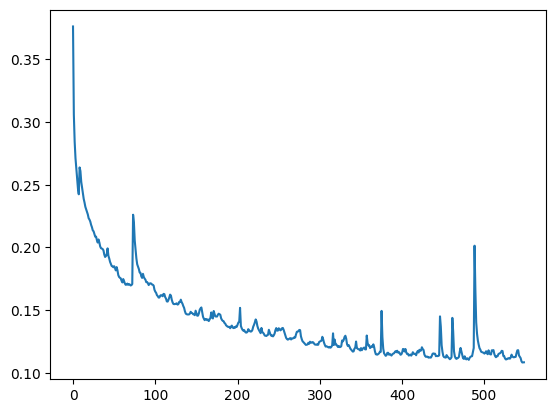
$\newline$ 
#### Perplexities
<!-- $\newline$  -->
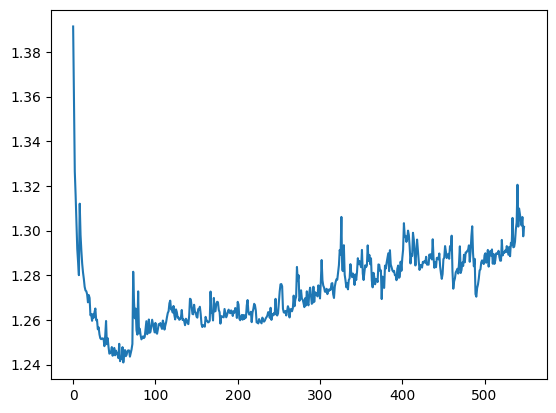

## 4. Output generating

При использовании argmax() наблюдалась генерация преимущественно пустой последовательности, потому используется softmax, решающий упомянутую проблему и избавляющий от детерминированности.

In [ ]:
model.eval()

In [ ]:
def softmax_with_temperature(logits, temperature=1.0):
    logits = logits / temperature
    exp_logits = torch.exp(logits - torch.max(logits))
    return exp_logits / torch.sum(exp_logits)

def generate_seq(input_seq, length, temperature=1.0):
    input_seq_copy = deepcopy(input_seq)
    
    for _ in range(length):
        logits = model(input_seq_copy)[-1]
        probabilities = softmax_with_temperature(logits, temperature)
        next_note = probabilities.multinomial(num_samples=1)
        input_seq_copy = torch.cat((input_seq_copy, next_note))
        
    return input_seq_copy

In [ ]:
def generate(input_path, output_path, start = 0, len_measures = train_window_len_measures, ouput_measure_number=5, softmax=True):
    input_tabs = torch.LongTensor(parse_gp5_to_fret_list(input_path)
                                  [start * NUM_BEATS_PER_MEASURE * NUM_STRINGS :
                                   (start + len_measures) * NUM_BEATS_PER_MEASURE * NUM_STRINGS]).to(device) + 1
    if softmax:
        input_tabs = generate_seq(input_tabs, ouput_measure_number * NUM_BEATS_PER_MEASURE * NUM_STRINGS)
    else:
        for i in range(ouput_measure_number * NUM_BEATS_PER_MEASURE * NUM_STRINGS):
            vectorized_c = model(input_tabs)[-1].argmax().unsqueeze(0)
            input_tabs = torch.cat((input_tabs, vectorized_c))
    create_gp5_from_fret_list(input_tabs - 1, output_path)

Для генерации достаточно в клетке ниже указать input_path — путь к файлу в формате .gp5, а также указать параметры генерации в аргументах функции generate (можно оставить значения по умолчанию)

In [ ]:
# inputs = {
#     0: "",
#     1: "--Табы--/Резерв от JR/Marcin Partzalek/System_Of_a_Down_-_Toxicity.gp5",
#     2: "--Табы--/Резерв от JR/Marcin Partzalek/System_of_a_Down_-_Aerials.gp5",
#     3: "--Табы--/Резерв от JR/presnyakov_igor-listen_to_your_heart.gp5",
#     4: "Dense.gp5",
#     5: "Unravel Full Version Tokyo Ghoul OP1.gp5",
#     6: "C:/Users/fsvuu/Downloads/beethoven-moonlight_sonata_6.gp5",
#     7: "Turkish March.gp5",
#     8: "1 Acoustic VS Electric - Marcin (Acoustic TAB).gp5",
#     9: "SHAPE_OF_YOU_-_MARCIN_PATRZALEK_TAB.gp5",
#     10: "3 Toccata - Marcin (TAB).gp5",
#     11: "Deja-Vu.gp5",
#     12: "Dumb_Ways_To_Die.gp5",
#     13: "I_Really_Want_to_Stay_at_Your_House.gp5",
#     14: "Tommy_Emmanuel_-_Guitar_Boogie.gp5",
#     15: "Tommy_Emmanuel_-_Angelina.gp5",
#     16: "Empty.gp5"
# }

# input_path = "Test/" + inputs[16]

input_path = "Test/Empty.gp5"

try:
    generate(input_path, "output.gp5", start=0, len_measures=train_window_len_measures, ouput_measure_number=4)
except:
    print("Не получилось :(")

Примеры генераций, сгенерированная часть начинается с 15-й секунды:
$\newline$ 

<audio controls src="output-shape_of_you.mp3" title="Title"></audio>

$\newline$

<audio controls src="output-toccata.mp3" title="Title"></audio>

$\newline$ 

<audio controls src="output-osamurisan.mp3" title="Title"></audio>

А также, вот что будет, если подать на вход 1 пустой такт:

<audio controls src="output-empty.mp3" title="Title"></audio>

<audio controls src="output-empty_8m.mp3" title="Title"></audio>

## 5. Conclusion

Цель достигнута, однако сгенерированные последовательности тяжело назвать музыкой (примеры выше — лучшее, что у меня получилось). По всей видимости, это предел выбранной архитектуры и инженерного решения о представлении табулатуры в понятном модели виде.

_Примечание: использованный для обучения датасет — моя личная коллекция, и не спрашивайте, откуда у меня столько табов :)_